In [1]:
!pip install pandas_market_calendars
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
!pip install pmdarima
!pip install statsmodels
!pip install neuralprophet[plotly]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 8.7 MB/s eta 0:00:00
E: Package 'libfluidsynth1' has no installation candidate
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107

In [2]:
!pip install ucimlrepo  # instalamos el paquete específico llamado ucimlrepo para acceder al dataset elegido

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import plotly.graph_objs as go
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings('ignore')
import itertools
from datetime import timedelta

In [4]:
# NeuralProphet
!pip install neuralprophet[live] --quiet
!pip install neuralprophet plotly

In [5]:
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
set_random_seed(0)

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


# 1. Procesamiento de los datos

In [107]:
#función diseñada para facilitar la descarga de datasets de la colección UCI Machine Learning Repository

from ucimlrepo import fetch_ucirepo
import pandas as pd

#Traigo el  dataset
air_quality = fetch_ucirepo(id=360)

#data (as pandas dataframes)
Xair = air_quality.data.features
yair = air_quality.data.targets

# variable information
print(air_quality.variables)

             name     role         type demographic  \
0            Date  Feature         Date        None   
1            Time  Feature  Categorical        None   
2          CO(GT)  Feature      Integer        None   
3     PT08.S1(CO)  Feature  Categorical        None   
4        NMHC(GT)  Feature      Integer        None   
5        C6H6(GT)  Feature   Continuous        None   
6   PT08.S2(NMHC)  Feature  Categorical        None   
7         NOx(GT)  Feature      Integer        None   
8    PT08.S3(NOx)  Feature  Categorical        None   
9         NO2(GT)  Feature      Integer        None   
10   PT08.S4(NO2)  Feature  Categorical        None   
11    PT08.S5(O3)  Feature  Categorical        None   
12              T  Feature   Continuous        None   
13             RH  Feature   Continuous        None   
14             AH  Feature   Continuous        None   

                                          description       units  \
0                                                N

In [108]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que vamos a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

# Cambiar el nombre de la variable C6H6(GT)
df.rename(columns={'C6H6(GT)': 'C6H6'}, inplace=True)

# Mostrar el DataFrame resultante
print(df.head())

        Date      Time  C6H6     T    RH
0  3/10/2004  18:00:00  11.9  13.6  48.9
1  3/10/2004  19:00:00   9.4  13.3  47.7
2  3/10/2004  20:00:00   9.0  11.9  54.0
3  3/10/2004  21:00:00   9.2  11.0  60.0
4  3/10/2004  22:00:00   6.5  11.2  59.6


In [109]:
# Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' pusimos dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [110]:
# Establecer la columna datetime como índice
df.set_index('Datetime', inplace=True)

In [111]:
# Eliminación de las columnas Date y Time
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [112]:
# Verificación numero de filas de la serie
num_filas = len(df)
print(num_filas)

9357


In [113]:
# Visualización df
print(df.head())

                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6


In [114]:
# Visualización df
print(df.tail())

                     C6H6     T    RH
Datetime                             
2005-04-04 10:00:00  13.5  21.9  29.3
2005-04-04 11:00:00  11.4  24.3  23.7
2005-04-04 12:00:00  12.4  26.9  18.3
2005-04-04 13:00:00   9.5  28.3  13.5
2005-04-04 14:00:00  11.9  28.5  13.1


In [115]:
# Reemplazar los valores -200 en la columna T con NaN
df['T'] = df['T'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['T'].fillna(method='ffill', inplace=True)

In [116]:
trace1 = go.Scatter(x=df.index, y=df['T'], mode='lines', name='T', line=dict(color='darkblue'))
fig = go.Figure(data=[trace1])

fig.update_layout(
    title='Serie Temporal de T',
    xaxis_title='Datetime',
    yaxis_title='Valores',
    legend_title='Series',
    plot_bgcolor='white',  # Fondo del área de trazado blanco
    paper_bgcolor='white'  # Fondo del papel blanco
)

fig.update_xaxes(
    tickmode='linear',
    tick0=df.index[0],
    dtick='M1',
    tickformat='%d.%m.%Y',
    gridcolor='lightgrey'
)

fig.update_yaxes(
    gridcolor='lightgrey'  #
)

fig.show()

# Neural Prophet

In [117]:
df_T = df['T']
print(df_T)

Datetime
2004-03-10 18:00:00    13.6
2004-03-10 19:00:00    13.3
2004-03-10 20:00:00    11.9
2004-03-10 21:00:00    11.0
2004-03-10 22:00:00    11.2
                       ... 
2005-04-04 10:00:00    21.9
2005-04-04 11:00:00    24.3
2005-04-04 12:00:00    26.9
2005-04-04 13:00:00    28.3
2005-04-04 14:00:00    28.5
Name: T, Length: 9357, dtype: float64


In [118]:
# Restablecer el índice para convertirlo en una columna
df_T = df_T.reset_index()

df_T['Datetime'] = pd.to_datetime(df_T['Datetime'])

# Renombrar las columnas para adaptarlas al formato esperado por NeuralProphet
df_T = df_T.rename(columns={'Datetime': 'ds', 'T': 'y'})

# Verificar la estructura del DataFrame
print(df_T.head())

                   ds     y
0 2004-03-10 18:00:00  13.6
1 2004-03-10 19:00:00  13.3
2 2004-03-10 20:00:00  11.9
3 2004-03-10 21:00:00  11.0
4 2004-03-10 22:00:00  11.2


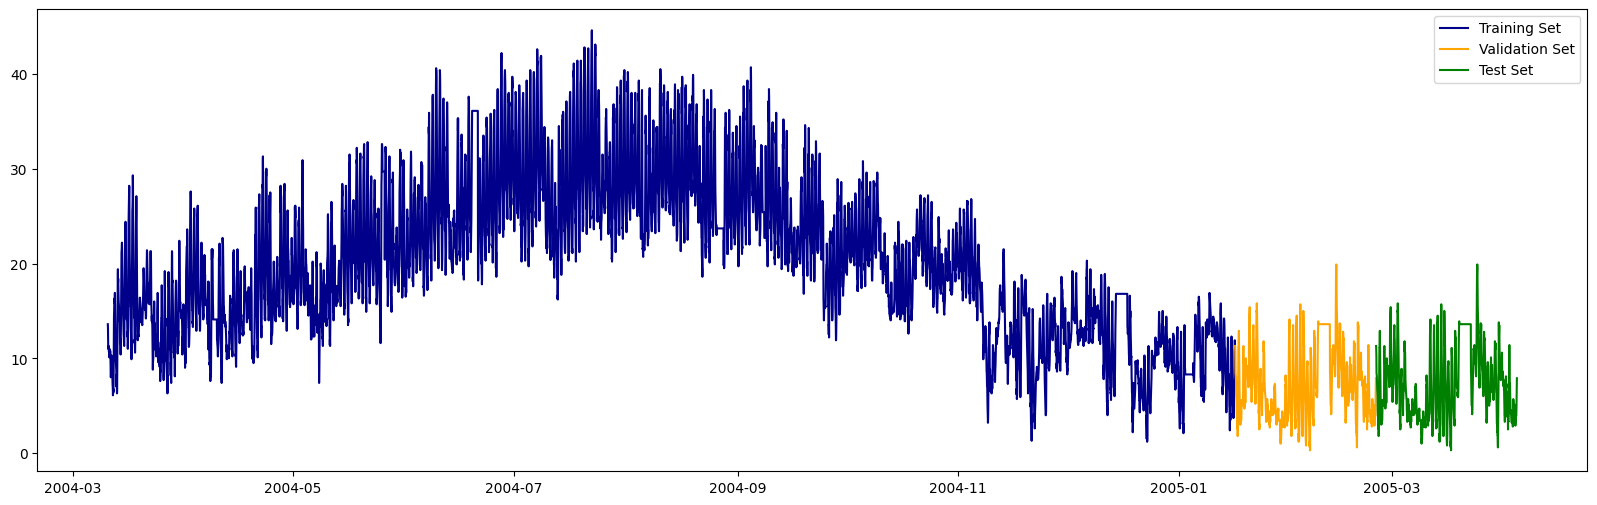

In [119]:
#Conjunto de train, validación y prueba para el modelo

train_size = 0.8

m = NeuralProphet()
df_train, df_valid = df_T[:int(len(df_T)*0.8)], df_T[int(len(df_T)*0.8):]
df_valid, df_test = df_valid[:len(df_valid)//2], df_valid[len(df_valid)//2:]

def train_valid_plot():

    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111)
    ax.plot(df_train['ds'].dt.to_pydatetime(), df_train["y"], color='darkblue', label='Training Set')
    ax.plot(df_valid['ds'].dt.to_pydatetime(), df_valid["y"], color='orange', label='Validation Set')
    ax.plot(df_test['ds'].dt.to_pydatetime(), df_valid["y"], color='green', label='Test Set')
    ax.legend()
    plt.show()

train_valid_plot()

In [120]:
m = NeuralProphet() #hiperparámetros predeterminados

metrics = m.fit(df=df_train, validation_df=df_valid, freq="H", progress="plot-all") # H frecuencia que es por hora, plot-all para que muestre el porgreso y metricas
metrics[-1:]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
59  3.207315     4.188  0.024494          0.0     59    0.013017       0.0   

         MAE      RMSE      Loss  RegLoss  
59  2.762185  3.490359  0.013017      0.0

In [20]:
n_epochs_used = len(metrics)
print(f"Número de épocas utilizadas: {n_epochs_used}")

Número de épocas utilizadas: 60


In [21]:
#Para conocer qué hiperparámetros se usaron por default
print(m.config)

{'growth': 'linear', 'changepoints': None, 'n_changepoints': 10, 'changepoints_range': 0.8, 'trend_reg': 0, 'trend_reg_threshold': False, 'trend_global_local': 'global', 'trend_local_reg': False, 'yearly_seasonality': 'auto', 'yearly_seasonality_glocal_mode': 'auto', 'weekly_seasonality': 'auto', 'weekly_seasonality_glocal_mode': 'auto', 'daily_seasonality': 'auto', 'daily_seasonality_glocal_mode': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'season_global_local': 'global', 'seasonality_local_reg': False, 'future_regressors_model': 'linear', 'future_regressors_d_hidden': 4, 'future_regressors_num_hidden_layers': 2, 'n_forecasts': 1, 'n_lags': 0, 'ar_layers': [], 'ar_reg': None, 'lagged_reg_layers': [], 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'SmoothL1Loss', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'quantiles': [], 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False

In [121]:
future = m.make_future_dataframe(df=df_train, periods=len(df_valid)+ len(df_test), n_historic_predictions=True)
forecast = m.predict(df=future)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [122]:
print(future)


                      ds     y
0    2004-03-10 18:00:00  13.6
1    2004-03-10 19:00:00  13.3
2    2004-03-10 20:00:00  11.9
3    2004-03-10 21:00:00  11.0
4    2004-03-10 22:00:00  11.2
...                  ...   ...
9352 2005-04-04 10:00:00   NaN
9353 2005-04-04 11:00:00   NaN
9354 2005-04-04 12:00:00   NaN
9355 2005-04-04 13:00:00   NaN
9356 2005-04-04 14:00:00   NaN

[9357 rows x 2 columns]


In [123]:
# Filtrar las predicciones para el conjunto de prueba
forecast_test = forecast[-len(df_test):]

# Mostrar las predicciones del conjunto de prueba
print(forecast_test)


                      ds   y     yhat1     trend  season_weekly  season_daily
8421 2005-02-24 15:00:00 NaN  8.449485  3.391723       0.289718      4.768044
8422 2005-02-24 16:00:00 NaN  8.469090  3.386813       0.303277      4.779001
8423 2005-02-24 17:00:00 NaN  7.736968  3.381902       0.316080      4.038986
8424 2005-02-24 18:00:00 NaN  6.451077  3.376992       0.328900      2.745186
8425 2005-02-24 19:00:00 NaN  5.173194  3.372081       0.340701      1.460413
...                  ...  ..       ...       ...            ...           ...
9352 2005-04-04 10:00:00 NaN -1.141679 -1.179919      -0.634694      0.672934
9353 2005-04-04 11:00:00 NaN  0.860920 -1.184830      -0.640040      2.685790
9354 2005-04-04 12:00:00 NaN  1.926111 -1.189740      -0.643004      3.758855
9355 2005-04-04 13:00:00 NaN  2.267323 -1.194651      -0.643286      4.105260
9356 2005-04-04 14:00:00 NaN  2.550521 -1.199566      -0.640152      4.390239

[936 rows x 6 columns]


In [25]:
# Graficos con potly
import plotly.graph_objects as go

In [124]:
fig = go.Figure()

# Agregar traza para valores reales
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Valores reales', line=dict(color='darkblue')))
fig.add_trace(go.Scatter(x=df_valid['ds'], y=df_valid['y'], mode='lines', name='Real - Valid', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real - Test', line=dict(color='green')))

# Agregar traza para predicciones
fig.add_trace(go.Scatter(x=forecast_test['ds'], y=forecast['yhat1'], mode='lines', name='Pronóstico', line=dict(color='skyblue')))

fig.update_layout(
    title= 'Pronóstico con NuralProphet para T - Modelo 1',
    xaxis_title='Datetime',
    yaxis_title='T',
    plot_bgcolor='white',  # Fondo del área de trazado blanco
    xaxis= dict(gridcolor='gray'),
    yaxis= dict(gridcolor='gray'))

fig.show()


**Agregar lags**

*Modelo 2*

In [126]:
#Separar entrenamiento, validacion y test
train_size = 0.8
df_train, df_valid = df_T[:int(len(df_T)*0.8)], df_T[int(len(df_T)*0.8):]
df_valid, df_test = df_valid[:len(df_valid)//2], df_valid[len(df_valid)//2:]


In [127]:
df= pd.concat([df_train, df_valid, df_test])

In [128]:
print(df)

                      ds     y
0    2004-03-10 18:00:00  13.6
1    2004-03-10 19:00:00  13.3
2    2004-03-10 20:00:00  11.9
3    2004-03-10 21:00:00  11.0
4    2004-03-10 22:00:00  11.2
...                  ...   ...
9352 2005-04-04 10:00:00  21.9
9353 2005-04-04 11:00:00  24.3
9354 2005-04-04 12:00:00  26.9
9355 2005-04-04 13:00:00  28.3
9356 2005-04-04 14:00:00  28.5

[9357 rows x 2 columns]


In [130]:
#Con lags de 24, para predecir, el  modelo utilizará las últimas 24 horas anteriores a ese valor

m2= NeuralProphet (daily_seasonality=True, seasonality_mode='additive', n_lags=24  )
metrics2 = m2.fit(df=df_train, validation_df=df_valid, freq="H", progress="plot-all")
metrics2[-1:]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
59  0.837314  1.102945  0.001703          0.0     59    0.001639       0.0   

         MAE      RMSE      Loss  RegLoss  
59  0.942272  1.259836  0.001639      0.0

In [131]:
future2= m2.make_future_dataframe(df=df, periods=len(df_valid)+len(df_test), n_historic_predictions=True )
forecast2 = m2.predict(df=future2)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.d

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [132]:
print(future2.tail())

                      ds     y
9353 2005-04-04 11:00:00  24.3
9354 2005-04-04 12:00:00  26.9
9355 2005-04-04 13:00:00  28.3
9356 2005-04-04 14:00:00  28.5
9357 2005-04-04 15:00:00   NaN


In [133]:
# Filtrar las predicciones para el conjunto de prueba
forecast_test2 = forecast2[-len(df_test):]

# Mostrar las predicciones del conjunto de prueba
print(forecast_test2)

                      ds     y      yhat1        ar1      trend  \
8422 2005-02-24 16:00:00   7.6   8.480671 -52.309246  55.544666   
8423 2005-02-24 17:00:00   7.2   8.240175 -51.872330  55.555523   
8424 2005-02-24 18:00:00   6.7   5.909163 -52.901203  55.566399   
8425 2005-02-24 19:00:00   6.1   4.885063 -52.599487  55.577255   
8426 2005-02-24 20:00:00   6.3   4.420252 -52.010914  55.588131   
...                  ...   ...        ...        ...        ...   
9353 2005-04-04 11:00:00  24.3  23.878702 -43.903728  65.660049   
9354 2005-04-04 12:00:00  26.9  25.818676 -43.007870  65.670906   
9355 2005-04-04 13:00:00  28.3  27.247637 -41.911613  65.681778   
9356 2005-04-04 14:00:00  28.5  28.534798 -40.898132  65.692650   
9357 2005-04-04 15:00:00   NaN  29.034897 -40.802872  65.703506   

      season_weekly  season_daily  
8422       0.462445      4.782807  
8423       0.474747      4.082235  
8424       0.485810      2.758158  
8425       0.494752      1.412545  
8426       0.50

In [134]:
fig = go.Figure()

# Agregar traza para los valores reales
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Real', line=dict(color='darkblue')))
fig.add_trace(go.Scatter(x=df_valid['ds'], y=df_valid['y'], mode='lines', name='Real - Valid', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real - Test', line=dict(color='green')))

# Agregar traza para el pronóstico
fig.add_trace(go.Scatter(x=forecast2['ds'], y=forecast2['yhat1'], mode='lines', name='Pronóstico', line=dict(color='skyblue')))

fig.update_layout(
    title='Pronóstico con NeuralProphet - Modelo 2',
    xaxis_title='Date Time',
    yaxis_title='T',
    plot_bgcolor='white', # Fondo blanco
    xaxis=dict(gridcolor='gray'),  # Grilla negra en el eje x
    yaxis=dict(gridcolor='gray'))  # Grilla negra en el eje y

fig.show()

**Performance**

In [135]:
# Calcular las métricas de rendimiento
mae = mean_absolute_error(df_test['y'], forecast_test2['yhat1'])
mse = mean_squared_error(df_test['y'], forecast_test2['yhat1'])
rmse = np.sqrt(mse)

# Imprimir las métricas de rendimiento
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 0.930328880632535
MSE: 1.3096690264315625
RMSE: 1.1444077186176098


***Forecasting***

In [136]:
## El Modelo 2 es el mejor modelo de los 6 probados, por lo que se selecciona este modelo para hacer un pronostico de 1 semana (168 horas)

#Crear el data frame con fechas futuras
# Última observación
last_date_train = pd.Timestamp('2005-04-04 14:00:00')

future_dates = pd.date_range(start=last_date_train, periods=169, freq='H')[1:]

df_future = pd.DataFrame({'ds': future_dates})

In [138]:
future = m2.make_future_dataframe(df=df, periods=168, n_historic_predictions=True)
forecast = m2.predict(df=future)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.d

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [139]:
future_forecast = m2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [143]:
fig = go.Figure()

# Agregar traza para los valores reales
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real - Test', line=dict(color='green')))

# Agregar traza para el pronóstico
fig.add_trace(go.Scatter(x=future_forecast['ds'], y=future_forecast['yhat1'], mode='lines', name='Pronóstico', line=dict(color='lightgreen')))

fig.update_layout(
    title='Pronóstico con NeuralProphet - Modelo 2',
    xaxis_title='Date Time',
    yaxis_title='T',
    plot_bgcolor='white', # Fondo blanco
    xaxis=dict(gridcolor='gray'),  # Grilla negra en el eje x
    yaxis=dict(gridcolor='gray'))  # Grilla negra en el eje y

fig.show()

*Modelo 3*

In [42]:
# con lag de 12
m3= NeuralProphet (daily_seasonality=True, seasonality_mode='additive', n_lags=12 )
metrics3 = m3.fit(df=df_train, validation_df=df_valid, freq="H", progress="plot-all")
metrics3[-1:]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
59   0.6474   0.86779  0.001054          0.0     59    0.001155       0.0   

         MAE      RMSE      Loss  RegLoss  
59  0.768162  1.056224  0.001154      0.0

In [46]:
future3= m3.make_future_dataframe(df=df, periods=len(df_valid)+len(df_test), n_historic_predictions=True )
forecast3 = m3.predict(df=future3)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.d

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [47]:
print(future3.tail())

                      ds     y
9353 2005-04-04 11:00:00  24.3
9354 2005-04-04 12:00:00  26.9
9355 2005-04-04 13:00:00  28.3
9356 2005-04-04 14:00:00  28.5
9357 2005-04-04 15:00:00   NaN


In [48]:
# Filtrar las predicciones para el conjunto de prueba
forecast_test3 = forecast3[-len(df_test):]

# Mostrar las predicciones del conjunto de prueba
print(forecast_test3)

                      ds     y      yhat1        ar1     trend  season_weekly  \
8422 2005-02-24 16:00:00   7.6   8.710592  -2.060524  5.362144       0.635789   
8423 2005-02-24 17:00:00   7.2   7.145943  -2.952385  5.358084       0.639153   
8424 2005-02-24 18:00:00   6.7   6.099696  -2.653658  5.354025       0.641002   
8425 2005-02-24 19:00:00   6.1   6.000626  -1.358883  5.349965       0.641185   
8426 2005-02-24 20:00:00   6.3   5.504369  -0.780668  5.345904       0.639567   
...                  ...   ...        ...        ...       ...            ...   
9353 2005-04-04 11:00:00  24.3  24.042728  20.441240  1.583046      -0.747842   
9354 2005-04-04 12:00:00  26.9  25.284126  20.641287  1.578987      -0.733355   
9355 2005-04-04 13:00:00  28.3  27.380484  22.420019  1.574928      -0.716031   
9356 2005-04-04 14:00:00  28.5  28.475235  23.275833  1.570869      -0.695713   
9357 2005-04-04 15:00:00   NaN  28.548243  22.968105  1.566809      -0.673114   

      season_daily  
8422  

In [50]:
fig = go.Figure()

# Agregar traza para los valores reales
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Real', line=dict(color='darkblue')))
fig.add_trace(go.Scatter(x=df_valid['ds'], y=df_valid['y'], mode='lines', name='Real - Valid', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real - Test', line=dict(color='green')))

# Agregar traza para el pronóstico
fig.add_trace(go.Scatter(x=forecast3['ds'], y=forecast3['yhat1'], mode='lines', name='Pronóstico', line=dict(color='skyblue')))

fig.update_layout(
    title='Pronóstico con NeuralProphet - Modelo 3',
    xaxis_title='Date Time',
    yaxis_title='T',
    plot_bgcolor='white', # Fondo blanco
    xaxis=dict(gridcolor='gray'),  # Grilla negra en el eje x
    yaxis=dict(gridcolor='gray'))  # Grilla negra en el eje y

fig.show()

In [51]:
# Calcular las métricas de rendimiento
mae = mean_absolute_error(df_test['y'], forecast_test3['yhat1'])
mse = mean_squared_error(df_test['y'], forecast_test3['yhat1'])
rmse = np.sqrt(mse)

# Imprimir las métricas de rendimiento
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 0.8042365251061245
MSE: 1.0339712967671872
RMSE: 1.0168437917237767


*Modelo 4*

In [55]:
# Se modifican los parametros: changepoints_range:0.99, n_changepoints=5, epochs=30.
# Me quedo con n_lags=24 (ya que el resultadod el modelo 2 fue ligeramente mejor que el modelo 3)

m4= NeuralProphet (changepoints_range=0.99, n_changepoints=5, epochs=30, daily_seasonality=True, seasonality_mode='additive', n_lags=24  )
metrics4 = m4.fit(df=df_train, validation_df=df_valid, freq="H", progress="plot-all")
metrics4[-1:]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
29  2.474703  3.074659  0.013237          0.0     29    0.010648       0.0   

         MAE      RMSE     Loss  RegLoss  
29  2.498247  3.210746  0.01065      0.0

In [56]:
future4= m4.make_future_dataframe(df=df, periods=len(df_valid)+len(df_test), n_historic_predictions=True )
forecast4 = m4.predict(df=future4)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.d

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [57]:
print(future4.tail())

                      ds     y
9353 2005-04-04 11:00:00  24.3
9354 2005-04-04 12:00:00  26.9
9355 2005-04-04 13:00:00  28.3
9356 2005-04-04 14:00:00  28.5
9357 2005-04-04 15:00:00   NaN


In [58]:
# Filtrar las predicciones para el conjunto de prueba
forecast_test4 = forecast4[-len(df_test):]

# Mostrar las predicciones del conjunto de prueba
print(forecast_test4)

                      ds     y      yhat1         ar1       trend  \
8422 2005-02-24 16:00:00   7.6  10.303457 -181.248718  186.309509   
8423 2005-02-24 17:00:00   7.2  10.776535 -180.090469  186.325516   
8424 2005-02-24 18:00:00   6.7   9.149774 -180.424850  186.341507   
8425 2005-02-24 19:00:00   6.1   6.485290 -181.781143  186.357498   
8426 2005-02-24 20:00:00   6.3   4.250651 -182.966156  186.373489   
...                  ...   ...        ...         ...         ...   
9353 2005-04-04 11:00:00  24.3  21.097803 -182.217529  201.197098   
9354 2005-04-04 12:00:00  26.9  22.830936 -181.522217  201.213089   
9355 2005-04-04 13:00:00  28.3  23.139704 -181.541992  201.229080   
9356 2005-04-04 14:00:00  28.5  22.748436 -182.230530  201.245071   
9357 2005-04-04 15:00:00   NaN  19.537666 -185.872101  201.261063   

      season_weekly  season_daily  
8422       0.443809      4.798847  
8423       0.457386      4.084095  
8424       0.469842      2.763263  
8425       0.480180      1.

In [69]:
fig = go.Figure()

# Agregar traza para los valores reales
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Real', line=dict(color='darkblue')))
fig.add_trace(go.Scatter(x=df_valid['ds'], y=df_valid['y'], mode='lines', name='Real - Valid', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real - Test', line=dict(color='green')))

# Agregar traza para el pronóstico
fig.add_trace(go.Scatter(x=forecast4['ds'], y=forecast4['yhat1'], mode='lines', name='Pronóstico', line=dict(color='skyblue')))

fig.update_layout(
    title='Pronóstico con NeuralProphet - Modelo 4',
    xaxis_title='Date Time',
    yaxis_title='T',
    plot_bgcolor='white', # Fondo blanco
    xaxis=dict(gridcolor='gray'),  # Grilla negra en el eje x
    yaxis=dict(gridcolor='gray'))  # Grilla negra en el eje y

fig.show()

In [70]:
# Calcular las métricas de rendimiento
mae = mean_absolute_error(df_test['y'], forecast_test4['yhat1'])
mse = mean_squared_error(df_test['y'], forecast_test4['yhat1'])
rmse = np.sqrt(mse)

# Imprimir las métricas de rendimiento
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 2.4372754143344033
MSE: 10.191436144706953
RMSE: 3.1924028794478545


*Modelo 5*

In [64]:
# Vuelvo a los parametros del Modelo 2 (hasta ahora los mejores resultados).
# Pruebo con activando el parametro yearly_seasonality=TRUE para ver si logro mejorar el Modelo.

m5= NeuralProphet (yearly_seasonality=True, daily_seasonality=True, seasonality_mode='additive', n_lags=24  )
metrics5 = m5.fit(df=df_train, validation_df=df_valid, freq="H", progress="plot-all")
metrics5[-1:]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 60
INFO:NP.config:Auto-set epochs to 60


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
59  0.725431  0.921176  0.001188          0.0     59    0.001074       0.0   

         MAE      RMSE      Loss  RegLoss  
59  0.740969  1.018442  0.001073      0.0

In [65]:
future5= m5.make_future_dataframe(df=df, periods=len(df_valid)+len(df_test), n_historic_predictions=True )
forecast5 = m5.predict(df=future5)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO:NP.d

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [66]:
print(future5.tail())

                      ds     y
9353 2005-04-04 11:00:00  24.3
9354 2005-04-04 12:00:00  26.9
9355 2005-04-04 13:00:00  28.3
9356 2005-04-04 14:00:00  28.5
9357 2005-04-04 15:00:00   NaN


In [67]:
# Filtrar las predicciones para el conjunto de prueba
forecast_test5 = forecast5[-len(df_test):]

# Mostrar las predicciones del conjunto de prueba
print(forecast_test5)

                      ds     y      yhat1        ar1      trend  \
8422 2005-02-24 16:00:00   7.6   8.277213  19.611563  31.944096   
8423 2005-02-24 17:00:00   7.2   6.915884  18.827475  31.949150   
8424 2005-02-24 18:00:00   6.7   6.309446  19.406385  31.954205   
8425 2005-02-24 19:00:00   6.1   5.710280  20.061049  31.959263   
8426 2005-02-24 20:00:00   6.3   5.392573  20.715921  31.964317   
...                  ...   ...        ...        ...        ...   
9353 2005-04-04 11:00:00  24.3  24.781857 -29.855137  36.649918   
9354 2005-04-04 12:00:00  26.9  26.157703 -29.524862  36.654976   
9355 2005-04-04 13:00:00  28.3  28.306141 -27.823086  36.660034   
9356 2005-04-04 14:00:00  28.5  28.945787 -27.476992  36.665085   
9357 2005-04-04 15:00:00   NaN  29.553282 -27.170774  36.670143   

      season_yearly  season_weekly  season_daily  
8422     -48.380348       0.426913      4.674991  
8423     -48.312756       0.436756      4.015262  
8424     -48.241322       0.445421      2.

In [68]:
fig = go.Figure()

# Agregar traza para los valores reales
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Real', line=dict(color='darkblue')))
fig.add_trace(go.Scatter(x=df_valid['ds'], y=df_valid['y'], mode='lines', name='Real - Valid', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real - Test', line=dict(color='green')))

# Agregar traza para el pronóstico
fig.add_trace(go.Scatter(x=forecast5['ds'], y=forecast5['yhat1'], mode='lines', name='Pronóstico', line=dict(color='skyblue')))

fig.update_layout(
    title='Pronóstico con NeuralProphet - Modelo 5',
    xaxis_title='Date Time',
    yaxis_title='T',
    plot_bgcolor='white', # Fondo blanco
    xaxis=dict(gridcolor='gray'),  # Grilla negra en el eje x
    yaxis=dict(gridcolor='gray'))  # Grilla negra en el eje y

fig.show()

In [71]:
# Calcular las métricas de rendimiento
mae = mean_absolute_error(df_test['y'], forecast_test5['yhat1'])
mse = mean_squared_error(df_test['y'], forecast_test5['yhat1'])
rmse = np.sqrt(mse)

# Imprimir las métricas de rendimiento
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 0.8179813012862818
MSE: 1.1976233576494595
RMSE: 1.094359793509182


*Modelo 6*

In [91]:
# El mejor modelo logrado hasta el momento es el Modelo 2.
# Vuelvo a esos parametros y pruebo incluyendo variables exogenas = C6H6 y RH

#Levantar de nuevo la serie (punto 1)
# Reemplazar los valores -200 en la columna T y RH con NaN, con C6H5 ya se hizo esto
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df.fillna(method='ffill', inplace=True)
print(df.head())


                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6


In [96]:
# Restablecer el índice para convertirlo en una columna
df = df.reset_index()
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Renombrar las columnas para adaptarlas al formato esperado por NeuralProphet
df = df.rename(columns={'Datetime': 'ds', 'T': 'y'})
print(df)

                      ds  C6H6     y    RH
0    2004-03-10 18:00:00  11.9  13.6  48.9
1    2004-03-10 19:00:00   9.4  13.3  47.7
2    2004-03-10 20:00:00   9.0  11.9  54.0
3    2004-03-10 21:00:00   9.2  11.0  60.0
4    2004-03-10 22:00:00   6.5  11.2  59.6
...                  ...   ...   ...   ...
9352 2005-04-04 10:00:00  13.5  21.9  29.3
9353 2005-04-04 11:00:00  11.4  24.3  23.7
9354 2005-04-04 12:00:00  12.4  26.9  18.3
9355 2005-04-04 13:00:00   9.5  28.3  13.5
9356 2005-04-04 14:00:00  11.9  28.5  13.1

[9357 rows x 4 columns]


In [97]:
train_size = 0.8
df_train, df_valid = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]
df_valid, df_test = df_valid[:len(df_valid)//2], df_valid[len(df_valid)//2:]
print (len(df_train))
print (len(df_valid))
print (len(df_test))

7485
936
936


In [98]:
m6= NeuralProphet (daily_seasonality=True, seasonality_mode='additive', n_lags=24)
m6.add_future_regressor(name='C6H6')
m6.add_future_regressor(name='RH')
metrics6 = m6.fit(df=df_train, validation_df=df_valid, freq="H", progress="plot-all")
metrics6[-1:]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO:NP.config:Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (117) is too small than the required number                     for the learning rate finder (246). The results might not be optimal.


Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MAE_val  RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss  \
59  0.830707  1.090071  0.001664          0.0     59    0.001298       0.0   

         MAE      RMSE      Loss  RegLoss  
59  0.855284  1.120261  0.001297      0.0

In [100]:
#No se hace la matriz con nuevos datos porque no interesa predecir a futuro sino, ver como se comporta la prediccion con los valores conocidos.
# Predecir los valores de df_train, df_valid y df_test
train_forecast = m6.predict(df_train)
valid_forecast = m6.predict(df_valid)
test_forecast = m6.predict(df_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in future regressors.
INFO:NP.data.processing:Dropped 1 rows at the end with NaNs in future regressors.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.893% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.893% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.893% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.893% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in future regressors.
INFO:NP.data.processing:Dropped 1 rows at the end with NaNs in future regressors.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.893% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.893% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.893% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.893% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in future regressors.
INFO:NP.data.processing:Dropped 1 rows at the end with NaNs in future regressors.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [103]:
# Mostrar las últimas predicciones del conjunto de entrenamiento, validacion y test
print("Predicciones del conjunto de entrenamiento:")
print(train_forecast.tail())

print("Predicciones del conjunto de validación:")
print(valid_forecast.tail())

print("Predicciones del conjunto de prueba:")
print(test_forecast.tail())

Predicciones del conjunto de entrenamiento:
                      ds     y      yhat1        ar1      trend  \
7479 2005-01-16 09:00:00   6.1   7.993424  93.522331 -73.326332   
7480 2005-01-16 10:00:00   9.0   9.452577  92.156281 -73.334198   
7481 2005-01-16 11:00:00  10.7   9.996706  91.088997 -73.342049   
7482 2005-01-16 12:00:00  11.1  10.959888  91.718849 -73.349915   
7483 2005-01-16 13:00:00  11.9  12.063940  92.510582 -73.357773   

      season_weekly  season_daily  future_regressors_additive  \
7479      -2.816814     -0.769060                   -8.616705   
7480      -3.177693      0.162422                   -6.354240   
7481      -3.551206      1.085335                   -5.284372   
7482      -3.909289      1.575175                   -5.074933   
7483      -4.280681      1.720637                   -4.528831   

      future_regressor_C6H6  future_regressor_RH  
7479               0.005176            -8.621881  
7480               0.002036            -6.356277  
7481     

In [105]:
#Crear la figura con Plotly
fig = go.Figure()

# Agregar trazas para los valores reales
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], mode='lines', name='Real - Train', line=dict(color='darkblue')))
fig.add_trace(go.Scatter(x=df_valid['ds'], y=df_valid['y'], mode='lines', name='Real - Validation', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y'], mode='lines', name='Real - Test', line=dict(color='green')))

# Agregar trazas para los pronósticos
fig.add_trace(go.Scatter(x=train_forecast['ds'], y=train_forecast['yhat1'], mode='lines', name='Pronostico', line=dict(color='skyblue')))
fig.add_trace(go.Scatter(x=valid_forecast['ds'], y=valid_forecast['yhat1'], mode='lines', name= 'Pronostico', line=dict(color='skyblue')))
fig.add_trace(go.Scatter(x=test_forecast['ds'], y=test_forecast['yhat1'], mode='lines', name='Pronóstico', line=dict(color='skyblue')))

# Actualizar el layout del gráfico
fig.update_layout(
    title='Pronóstico con NeuralProphet - Modelo 6',
    xaxis_title='Date Time',
    yaxis_title='C6H6',
    plot_bgcolor='white',  # Fondo blanco
    xaxis=dict(gridcolor='gray'),  # Grilla gris en el eje x
    yaxis=dict(gridcolor='gray')   # Grilla gris en el eje y
)

# Mostrar la figura
fig.show()